# MLFlow + whylogs Integration

In this notebook, we will explore the [MLFlow](https://mlflow.org/) integration in `whylogs`.

This example uses the data from [MLflow's tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html) for demonstration purpose.

This tutorial showcases how you can use the whylogs integration to:
* Capture data while training a linear regression model in `mlflow`
* Extract whylogs data back into in-memory format from MLflow backend
* Visualize the data from the backend

For more information about the data and the MLflow, please read the [MLflow's tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html).

# What You'll Need
To run this tutorial, you'll need to:
* Install [conda](https://conda.io/projects/conda/en/latest/user-guide/install/index.html)
* Create a new environment with conda via `conda create --name mlflow python=3.7`
    * You'll need to activate the environment with `conda activate whylogs-notebooks`
    * You'll need to install pip into the Conda environment `conda install pip`
    * To make the environment work with Jupyter notebooks, run `pip install ipykernel` to install the kernel module
    * Install the environment as a Jupyter notebook kernel via `python -m ipykernel install --user --name=mlflow`
* Install MLflow with scikit-learn. You can install this via `pip install mlflow[extras]`
* Install whylogs with matplotlib. You can install this via `pip install whylogs[viz]`
* You can install MLflow (via `pip install mlflow`), whylogs (via `pip install whylogs`), scikit-learn (via `pip install scikit-learn`), and matplotlib (via `pip install matplotlib`) separately.
* In your ntoebook, ensure you select `mlflow` as your kernel

# Setup the environment
First, we want to filter out noisy warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


In [2]:
import glob
import random
import time

import pandas as pd
import numpy as np
import mlflow
import whylogs

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

# Enable whylogs Integration

Enable WhyLogs in MLFlow to allow storage of WhyLogs statistical profiles. This method returns `True` if whylogs is able to patch MLflow

In [3]:
assert whylogs.__version__ >= "0.1.4" # we need 0.1.4 or later for MLFlow integration
whylogs.enable_mlflow()

True

# Dataset prepration

Download and prepare the UCI wine quality dataset. We sample test dataset further to represent batches of datasets produced every second.

In [4]:
# Load wine quality dataset
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(data_url, sep=";")

# Split the data into training and test sets
train, test = train_test_split(data)

# Relocate predicted variable "quality" to y vectors
train_x = train.drop(["quality"], axis=1).reset_index(drop=True)
test_x = test.drop(["quality"], axis=1).reset_index(drop=True)
train_y = train[["quality"]].reset_index(drop=True)
test_y = test[["quality"]].reset_index(drop=True)

# Sample from test data to collect "daily" data
subset_test_x = []
subset_test_y = []
for i in range(20):
    indices = random.sample(range(len(test)), 5)
    subset_test_x.append(test_x.loc[indices, :])
    subset_test_y.append(test_y.loc[indices, :])

# Train the model
Train an ElasticNet model using scikit-learn.

We then run this model for each of the batches of data, logging the model parameters, MAE evaluation metric, and WhyLogs dataset (from Pandas DataFrame).

Note that whylogs data is automatically logged when `mlflow.end_run()` is called (implicitly or explicitly).

In [5]:
model_params = {"alpha": 1.0,
                "l1_ratio": 2.0}

lr = ElasticNet(**model_params)
lr.fit(train_x, train_y)
print("Elasticnet model (%s):" % (model_params))

for i in range(20):
    predicted_output = lr.predict(subset_test_x[i])
    
    mae = mean_absolute_error(subset_test_y[i], predicted_output)
    print("  Subset %.0f, mean absolute error: %s" % (i, mae))
    
    mlflow.log_params(model_params)
    mlflow.log_metric("mae", mae)
    
    mlflow.whylogs.log_pandas(train)
    mlflow.end_run()
    
    time.sleep(1)

Elasticnet model ({'alpha': 1.0, 'l1_ratio': 2.0}):
  Subset 0, mean absolute error: 0.8722692599052502
  Subset 1, mean absolute error: 0.5297901323496811
  Subset 2, mean absolute error: 0.546909491944797
  Subset 3, mean absolute error: 0.8771724270439499
  Subset 4, mean absolute error: 0.913281295435134
  Subset 5, mean absolute error: 0.7651314675495765
  Subset 6, mean absolute error: 0.47614062473679086
  Subset 7, mean absolute error: 0.3634183288593441
  Subset 8, mean absolute error: 0.4722692599052502
  Subset 9, mean absolute error: 0.666594347215875
  Subset 10, mean absolute error: 0.6462183578291745
  Subset 11, mean absolute error: 0.6918735037412747
  Subset 12, mean absolute error: 0.5052869337343442
  Subset 13, mean absolute error: 0.7383046075634379
  Subset 14, mean absolute error: 1.0307413232217868
  Subset 15, mean absolute error: 0.559456554860201
  Subset 16, mean absolute error: 0.42739007190321326
  Subset 17, mean absolute error: 0.8513773693649705
  Subs

# Accessing whylogs Data From Your Experiement
Let's now collect the `experiment_id` from MLFlow for the previous experiment. Note that we have only 1 experiment in this demo.

In [6]:
client = mlflow.tracking.MlflowClient()
experiment = client.list_experiments()[0]

Inside of MLFlow, the profiles are stored as *artifacts*. These can be retrieved in the same way you store MLFlow projects, parameters, and metrics. Here is one example using MLFlow's Python API.

In [7]:
whylogs.mlflow.list_whylogs_runs(experiment_id="0")

[<RunInfo: artifact_uri='file:///Volumes/Workspace/whylogs-examples/python/mlruns/0/8c0b800b35cd49168984eec8be9bc8e8/artifacts', end_time=1603478931330, experiment_id='0', lifecycle_stage='active', run_id='8c0b800b35cd49168984eec8be9bc8e8', run_uuid='8c0b800b35cd49168984eec8be9bc8e8', start_time=1603478931074, status='FINISHED', user_id='andy'>,
 <RunInfo: artifact_uri='file:///Volumes/Workspace/whylogs-examples/python/mlruns/0/86ce66986a9d423cbc48a2848d68deb2/artifacts', end_time=1603478930062, experiment_id='0', lifecycle_stage='active', run_id='86ce66986a9d423cbc48a2848d68deb2', run_uuid='86ce66986a9d423cbc48a2848d68deb2', start_time=1603478929804, status='FINISHED', user_id='andy'>,
 <RunInfo: artifact_uri='file:///Volumes/Workspace/whylogs-examples/python/mlruns/0/3b60eb2698ee43398888952d9fe609cb/artifacts', end_time=1603478928795, experiment_id='0', lifecycle_stage='active', run_id='3b60eb2698ee43398888952d9fe609cb', run_uuid='3b60eb2698ee43398888952d9fe609cb', start_time=1603478

# Visualizing whylogs Data
Our integration allows you to quickly collect the statistical profiles produced during experimentation.

In [8]:
mlflow_profiles = whylogs.mlflow.get_experiment_profiles(experiment.experiment_id)
mlflow_profiles

You can then use `whylogs.viz` to easily produce visualizations for the WhyLogs profile data.

In [9]:
from whylogs.viz import ProfileVisualizer

viz = ProfileVisualizer()
viz.set_profiles(mlflow_profiles)

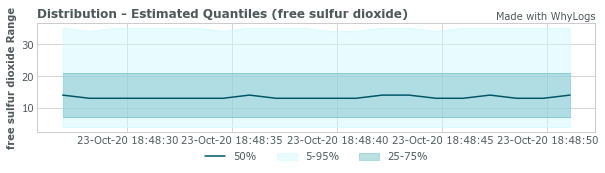

In [10]:
viz.plot_distribution("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

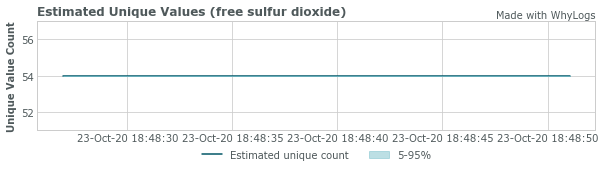

In [11]:
viz.plot_uniqueness("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

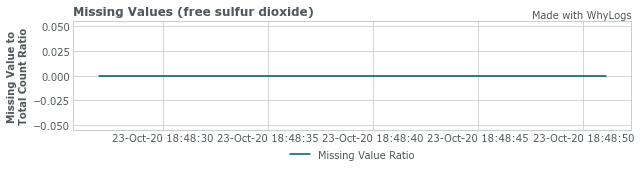

In [12]:
viz.plot_missing_values("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

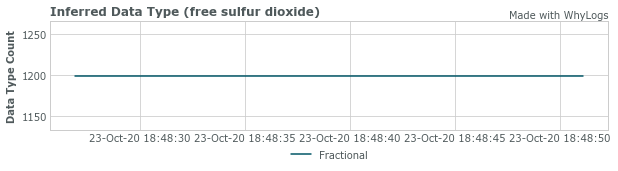

In [13]:
viz.plot_data_types("free sulfur dioxide", ts_format="%d-%b-%y %H:%M:%S")

whylogs data can be visualized in more complex ways. Check out [whylogs.viz](https://whylogs.readthedocs.io/en/latest/autoapi/whylogs/viz/index.html) for API details.

In addition, you can also check out how **WhyLabs** can help you visualize the data at [our sandbox](http://try.whylabsapp.com/)